In [4]:
import numpy as np
from math import ceil,log,log10,sqrt
import scipy.stats as st
import scipy.optimize as opt
import pandas as pd
from time import sleep
from tqdm import tqdm
import matplotlib.pyplot as plt

In [191]:
import warnings
warnings.filterwarnings('ignore')

# Stochastic Bandits

## Exploration Then Commit (ETC)

In [175]:
# a: the arm we choose to pull
# mu2: the true value of the mean for arm 2
def pullGaussian1(a,mu2):
        if a == 1:
            return np.random.normal(0,1)
        return np.random.normal(mu2,1)
    
def pullBernoulli1(a,p):
        if a == 1:
            p = 0.5
            return np.random.binomial(1,p)
        return np.random.binomial(1,p)

# m is the number of times we explore arm a
# n is the horizons or the number of times we play
# mu2 is the mean of arm bandit 2
def ETC(m,n,mu2,comment=False,gaussian=1):
    arm_means = [0,0]
    true_mean = [0,mu2]
    arm_pulls = [0,0]
    if gaussian == 1:
        mu1 = 0
        optimal = mu2 if mu2 > mu1 else mu1
    else:
        mu1 = 0.5
        optimal = mu2 if mu2 > mu1 else mu1
    
    # exploration phase
    exploration_regret = (optimal - mu2)*m + (optimal - mu1)*m
    
    if gaussian == 1:
        reward_1 = [pullGaussian1(1,mu2) for a in range(m)]
        reward_2 = [pullGaussian1(2,mu2) for a in range(m)]
    else:
        reward_1 = [pullBernoulli1(1,mu2) for a in range(m)]
        reward_2 = [pullBernoulli1(2,mu2) for a in range(m)]
    empirical_mean_1 = np.mean(reward_1)
    empirical_mean_2 = np.mean(reward_2)
    # exploitation phase
    best_mean = mu2 if empirical_mean_1 < empirical_mean_2 else mu1
    best_arm = 1 if empirical_mean_1 < empirical_mean_2 else 0
    if comment:
        print("arm1 mean:" + str(mu1))
        print("arm2 mean:" + str(mu2))
        print("best arm:" + str(best_arm))
        print("optimal arm:" + str(optimal))
    
    #reward_exploit = [pullGaussian(best_arm,mu2) for i in range(n - 2*m)]
    #reward = pullGaussian(best_arm,mu2)
    exploitation_regret = (optimal - best_mean)*(n-2*m)
    
        
    total_regret = exploitation_regret + exploration_regret
    
    if comment:
        print("exploration regret:" + str(exploration_regret))
        print("exploitation regret:" + str(exploitation_regret))
        print("total regret:" + str(total_regret))
        print("best arm true mean:" + str(true_mean[best_arm-1]))
        print("\n")
    
    
    return total_regret

In [140]:
# simulating ETC's N parameter
# Function takes in lists for m, n (horizon), and mu2 and
# performs a grid search of each set of parameters.
# Will ignore permutations where n <= m.
def simulationN_ETC(mu2,m,n=1000,num_sim=1000,gaussian=1):
    df = pd.DataFrame()
    df['mu2'] = mu2
    det = [determine_m(a) for a in mu2]
    for j in tqdm(m):            
        point_lst = []
        err_lst = []
        for i in tqdm(mu2):
            if j != 1000:
                simulation = [ETC(m=j,n=n,mu2=i,gaussian=gaussian) for a in range(num_sim)]
            else:
                simulation = [ETC(m=determine_m(i),n=n,mu2=i,gaussian=gaussian) for a in range(num_sim)]
            point = np.mean(simulation)
            err = np.var(simulation)
            point_lst += [point]
            err_lst += [err]
        
        df[str(j) + "point"] = point_lst
        df[str(j) + "error"] = err_lst
    return df

In [142]:
def determine_m(mu2):
    return int(max(1,np.ceil(4*np.log(250*mu2**2)/mu2**2)))

## Upper Confidence Bound Algorithms (UCB)

In [174]:
def pullGaussian(mu):
    return np.random.normal(mu,1)
    
def pullBernoulli(p):
    return np.random.binomial(1,p)

def simulationN_standard(mu2,n=1000,num_sim=1000,gaussian=True):
    point_lst = []
    var_lst = []
    df = pd.DataFrame()
    for m in tqdm(mu2):
        simulation = [UCB_standard(n=n,mu2=m,gaussian=1) for a in range(num_sim)]
        point = np.mean(simulation)
        var = np.var(simulation)
        point_lst += [point]
        var_lst += [var]
    df['point'] = point_lst
    df['var'] = var_lst
    return df

def simulationN_asymptotic(mu2,n=1000,num_sim=1000,gaussian=True):
    point_lst = []
    var_lst = []
    df = pd.DataFrame()
    for m in tqdm(mu2):
        simulation = [UCB_asymptotic(n=n,mu2=m,gaussian=1) for a in range(num_sim)]
        point = np.mean(simulation)
        var = np.var(simulation)
        point_lst += [point]
        var_lst += [var]
    df['point'] = point_lst
    df['var'] = var_lst
    return df

def simulationN_moss(mu2,n=1000,num_sim=1000,gaussian=True):
    point_lst = []
    var_lst = []
    df = pd.DataFrame()
    for m in tqdm(mu2):
        simulation = [UCB_moss(n=n,mu2=m,gaussian=1) for a in range(num_sim)]
        point = np.mean(simulation)
        var = np.var(simulation)
        point_lst += [point]
        var_lst += [var]
    df['point'] = point_lst
    df['var'] = var_lst
    return df

def simulationN_KL(mu2,n=1000,num_sim=1000,gaussian=True):
    point_lst = []
    var_lst = []
    df = pd.DataFrame()
    for m in tqdm(mu2):
        simulation = [UCB_KL(n=n,mu2=m,gaussian=1) for a in range(num_sim)]
        point = np.mean(simulation)
        var = np.var(simulation)
        point_lst += [point]
        var_lst += [var]
    df['point'] = point_lst
    df['var'] = var_lst
    return df

In [3]:
def UCB_standard(n,mu2,gaussian=1):
    if mu2 == 0:
        return 0
    reward = [pullGaussian(0),pullGaussian(mu2)] if gaussian else [pullBernoulli(0),pullBernoulli(mu2)]
    rewards1 = [reward[0]]
    rewards2 = [reward[1]]
    ti = [1,1]
    t = 2
    regret = 0
    optimal = 0 if mu2 < 0 else 1
    
    while(t < n):
        ucb = [np.mean(rewards1) + np.sqrt(2*log(n**2)/ti[0]),np.mean(rewards2) + np.sqrt(2*log(n**2)/ti[1])]
        argmax = np.argmax(ucb)
        reward = [pullGaussian(0),pullGaussian(mu2)] if gaussian else [pullBernoulli(0),pullBernoulli(mu2)]
        
        if argmax == 0:
            rewards1 += [reward[0]]
        else:
            rewards2 += [reward[1]]
        ti[argmax] += 1
        t+=1
        regret += 0 if optimal == argmax else mu2
    
    return regret

In [68]:
def UCB_asymptotic(n,mu2,gaussian=1):
    if mu2 == 0:
        return 0
    reward = [pullGaussian(0),pullGaussian(mu2)] if gaussian else [pullBernoulli(0),pullBernoulli(mu2)]
    rewards1 = [reward[0]]
    rewards2 = [reward[1]]
    ti = [1,1]
    t = 2
    regret = 0
    optimal = 0 if mu2 < 0 else 1
    
    while(t < n):
        ft = np.log(1 + t*np.log(np.log(t)))
        ucb = [np.mean(rewards1) + np.sqrt(2*ft/ti[0]),np.mean(rewards2) + np.sqrt(2*ft/ti[1])]
        argmax = np.argmax(ucb)
        reward = [pullGaussian(0),pullGaussian(mu2)] if gaussian else [pullBernoulli(0),pullBernoulli(mu2)]
        
        if argmax == 0:
            rewards1 += [reward[0]]
        else:
            rewards2 += [reward[1]]
        ti[argmax] += 1
        t+=1
        regret += 0 if optimal == argmax else mu2
    
    return regret

In [72]:
def log_plus(n,t):
    x = n / (2  *t)
    return max(np.log(1),np.log(x))

def UCB_moss(n,mu2,gaussian=1):
    if mu2 == 0: 
        return 0
    reward = [pullGaussian(0),pullGaussian(mu2)] if gaussian else [pullBernoulli(0),pullBernoulli(mu2)]
    rewards1 = [reward[0]]
    rewards2 = [reward[1]]
    ti = [1,1]
    t = 2
    regret = 0
    optimal = 0 if mu2 < 0 else 1
    
    while(t < n):
        if t != 1:
            ft = 1 + t*log(t)*log(t)
            
        ucb = [np.mean(rewards1) + np.sqrt((4/ti[0])*log_plus(n,ti[0])),np.mean(rewards2) + np.sqrt((4/ti[1])*log_plus(n,ti[1]))]
        argmax = np.argmax(ucb)
        reward = [pullGaussian(0),pullGaussian(mu2)] if gaussian else [pullBernoulli(0),pullBernoulli(mu2)]
        
        if argmax == 0:
            rewards1 += [reward[0]]
        else:
            rewards2 += [reward[1]]
        ti[argmax] += 1
        t+=1
        regret += 0 if optimal == argmax else mu2
    
    return regret

In [189]:
def d(p,q):
    if (p == 0):
        if (q < 1 and q > 0):
            return log(1/(1-q))
        else:
            return 0
    if (p == 1):
        if (q < 1 and q > 0):
            return log(1/q)
        else:
            return 1
    return p*log(p/q) + (1-p)*log((1-p)/(1-q))

def calculate_ucb(p,t,ti):
    ft = 1 + t*(log(log(t)))
    upper_bound = log(ft) / ti
    #bounds = [0,1]
    l = p
    r = np.array([1,1])
    for i in range(10):
        q = (l + r) / 2
        ndx = (np.where(p > 0, p * np.log(p / q), 0) +
             np.where(p < 1, (1 - p) * np.log((1 - p) / (1 - q)), 0)) < upper_bound
        l[ndx] = q[ndx]
        r[~ndx] = q[~ndx]
        #half = (sum(bounds)) / 2
        #if bounds[1]-bounds[0] < 1e-5:
            # early stopping
        #    break
        
        
        #entropy = d(p,half)
        
        #if (d(p,half) + d)
        #    bounds[0] = d(p,half) if p > 0 else 0
        #    bounds[1] = d(1-p,1-half) if p < 1 else 0

        #if entropy < upper_bound:
        #    bounds[0] = half
        #@else:
        #    bounds[1] = half
    #print(p)
    #print(half)
    return q

def UCB_KL(n,mu2,gaussian=1):
    if mu2 == 0.5:
        return 0
    reward = [pullBernoulli(0.5),pullBernoulli(mu2)]
    rewards1 = [reward[0]]
    rewards2 = [reward[1]]
    ti = [1,1]
    t = 2
    regret = 0
    optimal = 0 if mu2 < 0.5 else 1
    
    while(t < n): 
        ucb = calculate_ucb(np.array([np.mean(rewards1),np.mean(rewards2)]),t,ti[0])
        #print(ucb)
        argmax = np.argmax(ucb)
        
        reward = [pullBernoulli(0.5),pullBernoulli(mu2)]
        
        if argmax == 0:
            rewards1 += [reward[0]]
        else:
            rewards2 += [reward[1]]
        ti[argmax] += 1
        t+=1
        regret += 0 if optimal == argmax else abs(mu2-0.5)
    
    return regret

In [214]:
UCB_KL(1000,0.6,gaussian=1)

99.7999999999986

# Simulation Runs

In [145]:
df_ETC_1

,mu2,25point,25error,50point,50error,75point,75error,100point,100error,1000point,1000error
0,0.01,5.0475,0.150276,4.937,0.142360,4.5835,0.133817,4.856,0.126472,4.90020,1.578450e-01
1,0.02,9.5250,0.300191,9.316,0.283924,9.3540,0.268150,9.488,0.252590,9.70060,3.156111e-01
2,0.03,14.1165,0.449983,13.137,0.423035,13.2150,0.399419,13.368,0.376136,14.58084,4.734441e-01
3,0.04,18.2520,0.598584,17.480,0.563886,16.6680,0.527424,16.000,0.490143,20.19960,6.314749e-01
4,0.05,21.2950,0.742217,19.510,0.690352,20.1550,0.654612,19.360,0.607091,24.60080,7.892820e-01
...,...,...,...,...,...,...,...,...,...,...,...
95,0.96,24.0000,0.000000,48.000,0.000000,72.0000,0.000000,96.000,0.000000,23.95392,9.139200e-01
96,0.97,24.2500,0.000000,48.500,0.000000,72.7500,0.000000,97.000,0.000000,23.28000,2.248058e-16
97,0.98,24.5000,0.000000,49.000,0.000000,73.5000,0.000000,98.000,0.000000,23.47492,9.349200e-01
98,0.99,25.6905,0.940500,49.500,0.000000,74.2500,0.000000,99.000,0.000000,22.77000,0.000000e+00


In [206]:
mu2_fast = [0.01*i for i in range(0,101,10)]

In [233]:
UCB_KL(n=1000,mu2=0.4,gaussian=1)

0

In [168]:
# Simulation Runs

# ETC 
mu2 = [0.01*i for i in range(1,101)]
m = [25,50,75,100,1000]
df_ETC_1 = simulationN(mu2,m,gaussian=1,num_sim=1000)
df_ETC_2 = simulationN(mu2,m,gaussian=2,num_sim=1000)

 64%|███████████████████████████████████████████████████▊                             | 64/100 [00:13<00:07,  4.85it/s]


 28%|██████████████████████▋                                                          | 28/100 [00:11<00:27,  2.60it/s]


 94%|████████████████████████████████████████████████████████████████████████████▏    | 94/100 [00:38<00:02,  2.62it/s]


 58%|██████████████████████████████████████████████▉                                  | 58/100 [00:33<00:24,  1.72it/s]


 22%|█████████████████▊                                                               | 22/100 [00:17<01:02,  1.24it/s]


 88%|███████████████████████████████████████████████████████████████████████▎         | 88/100 [01:07<00:11,  1.05it/s]


 58%|██████████████████████████████████████████████▉                                  | 58/100 [01:02<00:22,  1.91it/s]


 21%|█████████████████                                                                | 21/100 [00:04<00:16,  4.77it/s]


 87%|██████████████████████████████████████████████████████████████████████▍          | 87/100 [00:18<00:02,  4.74it/s]


 51%|█████████████████████████████████████████▎                                       | 51/100 [00:18<00:17,  2.75it/s]


 15%|████████████▏                                                                    | 15/100 [00:07<00:44,  1.92it/s]


 81%|█████████████████████████████████████████████████████████████████▌               | 81/100 [00:45<00:10,  1.82it/s]


 45%|████████████████████████████████████▍                                            | 45/100 [00:31<00:37,  1.45it/s]


 14%|███████████▎                                                                     | 14/100 [00:17<02:42,  1.89s/it]


 80%|████████████████████████████████████████████████████████████████▊                | 80/100 [01:03<00:05,  3.70it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [04:11<00:00, 50.24s/it]


In [170]:
%store df_ETC_1
%store df_ETC_2

Stored 'df_ETC_1' (DataFrame)
Stored 'df_ETC_2' (DataFrame)


In [11]:
mu2 = [0.01*x for x in range(101)]

In [ ]:
df = simulationN_standard(mu2) 

 22%|█████████████████▏                                                            | 22/100 [37:11<2:26:24, 112.62s/it]

In [ ]:
%store df

In [ ]:
df2 = simulationN_asymptotic(mu2) 

In [ ]:
%store df2

In [ ]:
df3 = simulationN_moss(mu2) 

In [ ]:
%store df3

In [207]:
df4 = simulationN_KL(mu2_fast,num_sim=1000)

 18%|██████████████▌                                                                 | 2/11 [14:16<1:04:13, 428.19s/it]


KeyboardInterrupt: 

In [203]:
df4

,point,var
0,0.0000,0.000000
1,4.5090,1996.593219
2,23.9720,8987.021616
3,14.0630,4682.908881
4,38.9040,10098.687384
5,20.1325,4575.066819
6,24.4660,4171.557644
7,35.9625,4080.225769
8,20.0540,1585.885884
9,15.4470,527.938891


# Plots

Text(0, 0.5, 'Average Total Regret')

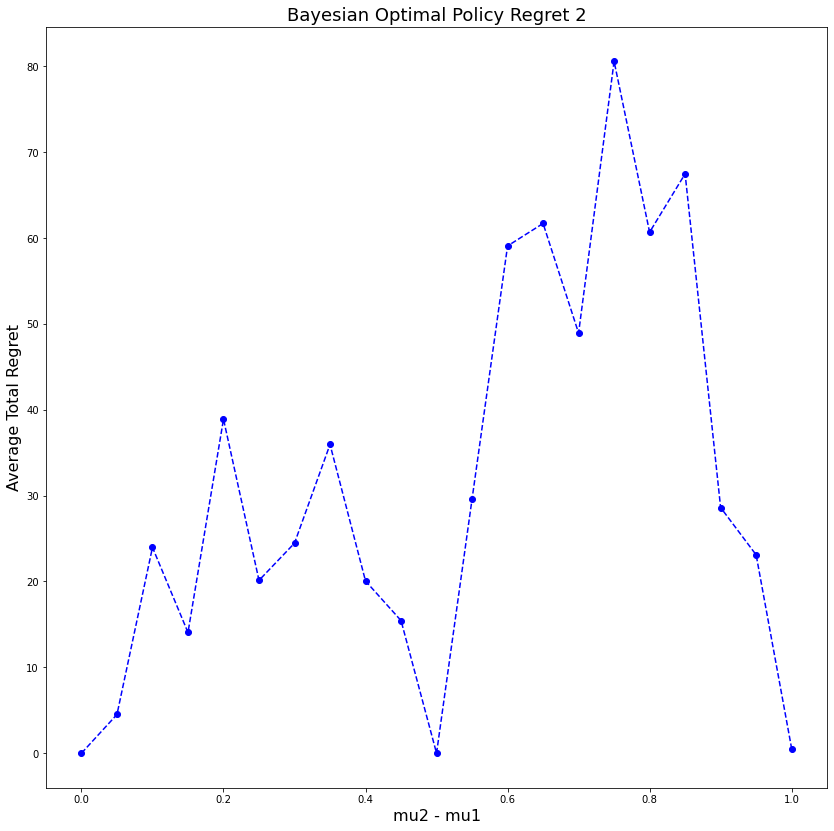

In [205]:
fig, ax = plt.subplots()
fig.set_figheight(14)
fig.set_figwidth(14)
plt.plot(mu2_fast,df4['point'],"--bo",color='blue')
#plt.plot(mu2,df2['point'],"--bo",color='green')
#plt.plot(mu2,df33['point'],"--bo",color='red')
#plt.plot(sim44['mu1'],sim44['regret'],"--bo",color='black')

ax.set_title("Bayesian Optimal Policy Regret 2",fontsize=18)
ax.set_xlabel('mu2 - mu1', fontsize=16)
ax.set_ylabel('Average Total Regret', fontsize=16)
#plt.legend(['[1,1]', '[1,3]','[10,10]','[10,30]'],prop={'size': 18})
#ax.tick_params(axis='both', which='major', labelsize=16)

C:\Users\erics\AppData\Local\Temp/ipykernel_104044/2527884800.py:4: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "--bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot(mu2,df['point'],"--bo",color='blue')
C:\Users\erics\AppData\Local\Temp/ipykernel_104044/2527884800.py:5: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "--bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot(mu2,df2['point'],"--bo",color='green')


Text(0, 0.5, 'Average Total Regret')

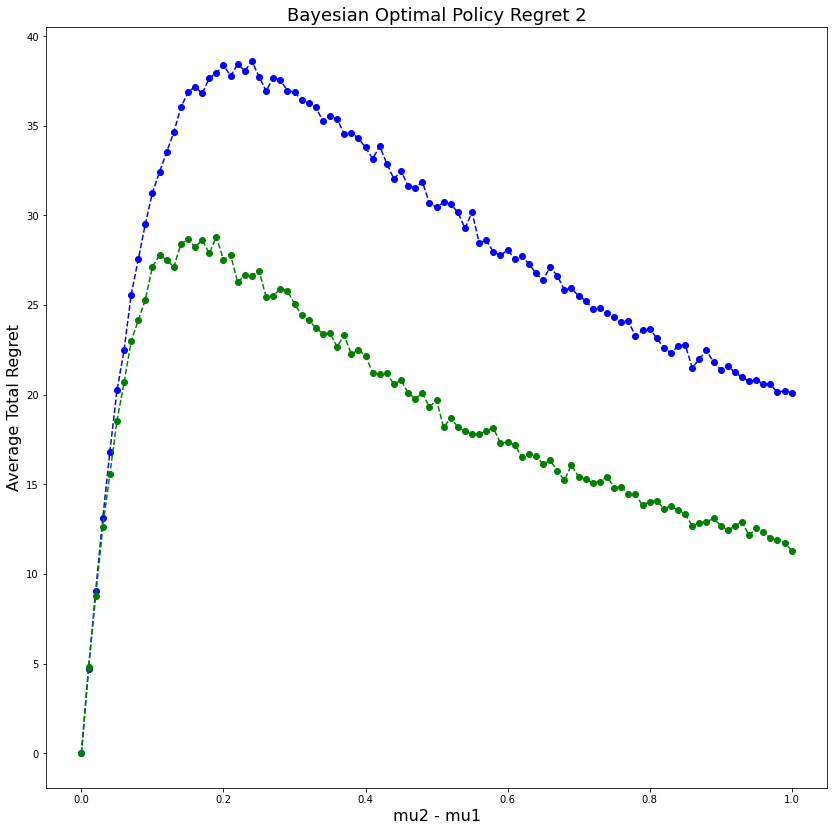

In [78]:
fig, ax = plt.subplots()
fig.set_figheight(14)
fig.set_figwidth(14)
plt.plot(mu2,df['point'],"--bo",color='blue')
plt.plot(mu2,df2['point'],"--bo",color='green')
#plt.plot(mu2,df33['point'],"--bo",color='red')
#plt.plot(sim44['mu1'],sim44['regret'],"--bo",color='black')

ax.set_title("Bayesian Optimal Policy Regret 2",fontsize=18)
ax.set_xlabel('mu2 - mu1', fontsize=16)
ax.set_ylabel('Average Total Regret', fontsize=16)
#plt.legend(['[1,1]', '[1,3]','[10,10]','[10,30]'],prop={'size': 18})
#ax.tick_params(axis='both', which='major', labelsize=16)